In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cv2
import torch
from tqdm.auto import tqdm, trange
from PIL import Image, ImageDraw
from extract import extract_keypoints
from glob import glob
import matplotlib.pyplot as plt
import copy


In [2]:
class SuperPointNet(torch.nn.Module):
    """ Pytorch definition of SuperPoint Network. """

    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = torch.nn.ReLU(inplace=True)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = torch.nn.Conv2d(
            1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = torch.nn.Conv2d(
            c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = torch.nn.Conv2d(
            c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = torch.nn.Conv2d(
            c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = torch.nn.Conv2d(
            c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = torch.nn.Conv2d(
            c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = torch.nn.Conv2d(
            c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = torch.nn.Conv2d(
            c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = torch.nn.Conv2d(
            c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = torch.nn.Conv2d(
            c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = torch.nn.Conv2d(
            c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = torch.nn.Conv2d(
            c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """ Forward pass that jointly computes unprocessed point and descriptor
        tensors.
        Input
          x: Image pytorch tensor shaped N x 1 x H x W.
        Output
          semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
          desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
        """
        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1)  # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1))  # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    """ Wrapper around pytorch net to help with pre and post image processing. """

    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,
                 cuda=False):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh  # L2 descriptor distance for good match.
        self.cell = 8  # Size of each output cell. Keep this fixed.
        self.border_remove = 4  # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
            # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
            # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path,
                                                map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):
        """
        Run a faster approximate Non-Max-Suppression on numpy corners shaped:
          3xN [x_i,y_i,conf_i]^T

        Algo summary: Create a grid sized HxW. Assign each corner location a 1, rest
        are zeros. Iterate through all the 1's and convert them either to -1 or 0.
        Suppress points by setting nearby values to 0.

        Grid Value Legend:
        -1 : Kept.
         0 : Empty or suppressed.
         1 : To be processed (converted to either kept or supressed).

        NOTE: The NMS first rounds points to integers, so NMS distance might not
        be exactly dist_thresh. It also assumes points are within image boundaries.

        Inputs
          in_corners - 3xN numpy array with corners [x_i, y_i, confidence_i]^T.
          H - Image height.
          W - Image width.
          dist_thresh - Distance to suppress, measured as an infinty norm distance.
        Returns
          nmsed_corners - 3xN numpy matrix with surviving corners.
          nmsed_inds - N length numpy vector with surviving corner indices.
        """
        grid = np.zeros((H, W)).astype(int)  # Track NMS data.
        inds = np.zeros((H, W)).astype(int)  # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2, :])
        corners = in_corners[:, inds1]
        rcorners = corners[:2, :].round().astype(int)  # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3, 0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3, 1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1, i], rcorners[0, i]] = 1
            inds[rcorners[1, i], rcorners[0, i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad, pad), (pad, pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
            # Account for top and left padding.
            pt = (rc[0] + pad, rc[1] + pad)
            if grid[pt[1], pt[0]] == 1:  # If not yet suppressed.
                grid[pt[1] - pad:pt[1] + pad + 1,
                     pt[0] - pad:pt[0] + pad + 1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid == -1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        """ Process a numpy image to extract points and descriptors.
        Input
          img - HxW numpy float32 input image in range [0,1].
        Output
          corners - 3xN numpy array with corners [x_i, y_i, confidence_i]^T.
          desc - 256xN numpy array of corresponding unit normalized descriptors.
          heatmap - HxW numpy heatmap in range [0,1] of point confidences.
          """
        # === convert image =========================
        if img.ndim != 2:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        if img.dtype != np.float32:
            img = img.astype('float32')
        if np.max(img) > 1.0:
            img = img / 255.0
        # ===========================================

        assert img.ndim == 2, 'Image must be grayscale.'
        assert img.dtype == np.float32, 'Image must be float32.'
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        # --- Process points.
        dense = np.exp(semi)  # Softmax.
        dense = dense / (np.sum(dense, axis=0) + .00001)  # Should sum to 1.
        # Remove dustbin.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = nodust.transpose(1, 2, 0)
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc * self.cell, Wc * self.cell])
        xs, ys = np.where(heatmap >= self.conf_thresh)  # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        pts = np.zeros((3, len(xs)))  # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heatmap[xs, ys]
        # Apply NMS.
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist)
        inds = np.argsort(pts[2, :])
        pts = pts[:, inds[::-1]]  # Sort by confidence.
        # Remove points along border.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W - bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H - bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
            # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W) / 2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H) / 2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()
            desc = torch.nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]
        return pts, desc, heatmap

In [3]:
def load_image_sp(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.astype('float32')
    if np.max(img) > 1.0:
        img = img / 255.0
    return img

def r2d2_args(img_path):
    args = {}
    args['model'] = 'models/r2d2_WASF_N16.pt'
    args['images'] = img_path
    args['top-k'] = 300
    args['scale-f'] = 2**0.25
    args['min-size'] = 256
    args['max-size'] = 1024
    args['min-scale'] = 0
    args['max-scale'] = 1
    args['reliability-thr'] = 0.7
    args['repeatability-thr'] = 0.7
    args['gpu'] = [0]
    return args

def sp_model():
    sp = SuperPointFrontend(weights_path="models/superpoint_v1.pth",
                            nms_dist=4,
                            conf_thresh=0.015,
                            nn_thresh=0.7,
                            cuda=True)
    return sp

def extract_sp(sp, img_path):
    img = load_image_sp(img_path)
    sp_kpts, sp_descs, sp_scores = sp.run(img)
    return sp_kpts, sp_descs, sp_scores

def extract_both(sp, img_path):
    res = {}
    # Superpoint
    img = load_image_sp(img_path)
    sp_kpts, sp_descs, sp_scores = sp.run(img)
    # R2D2
    _r2_args = r2d2_args(img_path)
    r2_kpts, r2_descs, r2_scores = extract_keypoints(_r2_args)
    return sp_kpts.T, sp_descs.T, sp_scores.T, r2_kpts, r2_descs, r2_scores

def draw_kpts(img_path, kpts):
    # img = cv2.imread(img_path)
    img = Image.open(img_path)
    if len(kpts) > 2:
        kpts = kpts[:, :2].astype(np.int32)
    # draw_kpts = cv2.drawKeypoints(img, kpts, None)
    draw = ImageDraw.Draw(img)
    for kpt in kpts:
        # draw.point((kpt[0], kpt[1]), (255, 0, 0))
        draw.ellipse(((kpt[0]-2, kpt[1]-2), (kpt[0]+2, kpt[1]+2)), fill=(255, 0, 0))
    return img

def draw_both(img_path, sp_kpts, r2_kpts):
    sp_img = Image.open(img_path)
    r2_img = copy.deepcopy(sp_img)
    if len(sp_kpts) > 2:
        sp_kpts = sp_kpts[:, :2].astype(np.int32)
    sp_draw = ImageDraw.Draw(sp_img)
    r2_draw = ImageDraw.Draw(r2_img)
    
    for kpt in sp_kpts:
        sp_draw.ellipse(((kpt[0]-2, kpt[1]-2), (kpt[0]+2, kpt[1]+2)), fill=(255, 0, 0))
    for kpt in r2_kpts:
        r2_draw.ellipse(((kpt[0]-2, kpt[1]-2), (kpt[0]+2, kpt[1]+2)), fill=(255, 0, 0))
    
    plt.rcParams['figure.figsize'] = (10, 5)
    plt.subplot(1, 2, 1)
    plt.title('Superpoint')
    plt.imshow(sp_img)
    plt.subplot(1, 2, 2)
    plt.title('R2D2')
    plt.imshow(r2_img)
    plt.tight_layout()
    plt.show()
    return 

# def sg_matching():

def make_matching_plot_fast(image0, image1, kpts0, kpts1, mkpts0,
                            mkpts1, color, text, path=None,
                            show_keypoints=False, margin=10,
                            opencv_display=False, opencv_title='',
                            small_text=[]):
    H0, W0 = image0.shape
    H1, W1 = image1.shape
    H, W = max(H0, H1), W0 + W1 + margin

    out = 255*np.ones((H, W), np.uint8)
    out[:H0, :W0] = image0*255
    out[:H1, W0+margin:] = image1*255
    out = np.stack([out]*3, -1)
    if show_keypoints:
        kpts0, kpts1 = np.round(kpts0).astype(int), np.round(kpts1).astype(int)
        white = (255, 255, 255)
        black = (0, 0, 0)
        for x, y in kpts0:
            cv2.circle(out, (x, y), 2, black, -1, lineType=cv2.LINE_AA)
            cv2.circle(out, (x, y), 1, white, -1, lineType=cv2.LINE_AA)
        for x, y in kpts1:
            cv2.circle(out, (x + margin + W0, y), 2, black, -1,
                       lineType=cv2.LINE_AA)
            cv2.circle(out, (x + margin + W0, y), 1, white, -1,
                       lineType=cv2.LINE_AA)

    mkpts0, mkpts1 = np.round(mkpts0).astype(int), np.round(mkpts1).astype(int)
    color = (np.array(color[:, :3])*255).astype(int)[:, ::-1]
    for (x0, y0, _), (x1, y1, __), c in zip(mkpts0, mkpts1, color):
        c = c.tolist()
        cv2.line(out, (x0, y0), (x1 + margin + W0, y1),
                 color=c, thickness=1, lineType=cv2.LINE_AA)
        # display line end-points as circles
        cv2.circle(out, (x0, y0), 2, c, -1, lineType=cv2.LINE_AA)
        cv2.circle(out, (x1 + margin + W0, y1), 2, c, -1,
                   lineType=cv2.LINE_AA)

    # Scale factor for consistent visualization across scales.
    sc = min(H / 640., 2.0)

    # Big text.
    Ht = int(30 * sc)  # text height
    txt_color_fg = (255, 255, 255)
    txt_color_bg = (0, 0, 0)
    for i, t in enumerate(text):
        cv2.putText(out, t, (int(8*sc), Ht*(i+1)), cv2.FONT_HERSHEY_DUPLEX,
                    1.0*sc, txt_color_bg, 2, cv2.LINE_AA)
        cv2.putText(out, t, (int(8*sc), Ht*(i+1)), cv2.FONT_HERSHEY_DUPLEX,
                    1.0*sc, txt_color_fg, 1, cv2.LINE_AA)

    # Small text.
    Ht = int(18 * sc)  # text height
    for i, t in enumerate(reversed(small_text)):
        cv2.putText(out, t, (int(8*sc), int(H-Ht*(i+.6))), cv2.FONT_HERSHEY_DUPLEX,
                    0.5*sc, txt_color_bg, 2, cv2.LINE_AA)
        cv2.putText(out, t, (int(8*sc), int(H-Ht*(i+.6))), cv2.FONT_HERSHEY_DUPLEX,
                    0.5*sc, txt_color_fg, 1, cv2.LINE_AA)

    if path is not None:
        cv2.imwrite(str(path), out)

    if opencv_display:
        cv2.imshow(opencv_title, out)
        cv2.waitKey(1)

    return out
    

sp = sp_model()

In [45]:
imgs = glob('imgs/1024/*.png')
imgs = sorted(imgs)
imgs[:5]

['imgs/1024/002-02.png',
 'imgs/1024/10_1.png',
 'imgs/1024/10_2.png',
 'imgs/1024/10_3.png',
 'imgs/1024/10_4.png']

/home/muyaho/.conda/envs/pnp/lib/python3.8/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Launching on GPUs 0

>> Creating net = Quad_L2Net_ConfCFS()
 ( Model size: 486K parameters )

Extracting features for imgs/2048/11_1.png


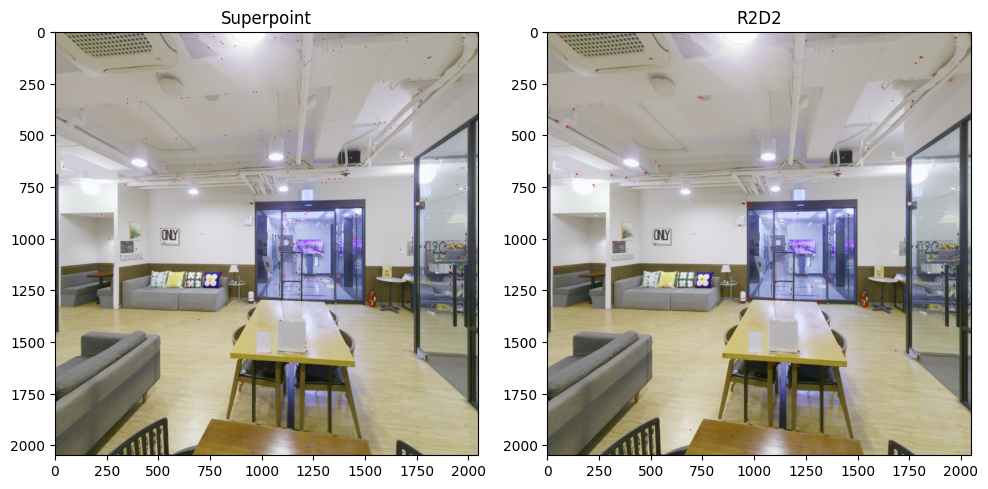

In [31]:
def show_points(idx):
    sp_kpts, sp_descs, sp_scores, r2_kpts, r2_descs, r2_scores = extract_both(sp, imgs[idx])
    draw_both(imgs[idx], sp_kpts[:300], r2_kpts)

# show_points(0*6+1)
# show_points(1*6+1)
show_points(1*4+0)

In [17]:
# sp_kpts, sp_descs, sp_scores, r2_kpts, r2_descs, r2_scores = extract_both(sp, imgs[1*6+1])

In [10]:
def filter_kpts(kpts, descs, scores=None, threshold=10):
    valid_pts = []
    valid_descs = []
    valid_scores = []
    for i, pts in enumerate(kpts):
        
        valid = True
        for vpts in valid_pts:
            distance = np.sqrt((vpts[0] - pts[0])**2 + (vpts[1] - pts[1])**2)
            if distance < threshold:
                valid = False
        if valid:
            valid_pts.append(pts)
            valid_descs.append(descs[i])
            if scores:
                valid_scores.append(scores[i])
    if scores:    
        return np.array(valid_pts), np.array(valid_descs), np.array(valid_scores)

    return np.array(valid_pts), np.array(valid_descs)


In [83]:

from models.superpoint import SuperPoint
from models.superglue import SuperGlue
import matplotlib.cm as cm

def draw_glue(idx0, idx1, method = 'r2', threshold=5, k=20, epi=False):
    image0 = load_image_sp(imgs[idx0])
    image1 = load_image_sp(imgs[idx1])
    sp_kpts0, sp_descs0, sp_scores0, r2_kpts0, r2_descs0, r2_scores0 = extract_both(sp, imgs[idx0])
    sp_kpts1, sp_descs1, sp_scores1, r2_kpts1, r2_descs1, r2_scores1 = extract_both(sp, imgs[idx1])
    print(sp_kpts0.shape, sp_descs0.shape, sp_scores0.shape, r2_kpts0.shape, r2_descs0.shape, r2_scores0.shape)
#     sp_kpts0, sp_descs0 = filter_kpts(sp_kpts0, sp_descs0, threshold=threshold)
#     sp_kpts1, sp_descs1 = filter_kpts(sp_kpts1, sp_descs1, threshold=threshold)
#     r2_kpts0, r2_descs0 = filter_kpts(r2_kpts0, r2_descs0, threshold=threshold)
#     r2_kpts1, r2_descs1 = filter_kpts(r2_kpts1, r2_descs1, threshold=threshold)
#     print(sp_kpts0.shape, sp_descs0.shape, sp_scores0.shape, r2_kpts0.shape, r2_descs0.shape, r2_scores0.shape)
                   
    glue_config = {
                'weights': 'indoor',
                'sinkhorn_iterations': 20,
                'match_threshold': 0.2,
            }

    glue_input_sp = {
        'image0': torch.Tensor(image0),    'image1': torch.Tensor(image1),    'keypoints0': torch.Tensor(sp_kpts0),
        'keypoints1':torch.Tensor(sp_kpts1),    'descriptors0':torch.Tensor(sp_descs0),    'descriptors1':torch.Tensor(sp_descs1),
        'scores0': torch.Tensor(sp_kpts0[:, 2]), 'scores1': torch.Tensor(sp_kpts1[:, 2]), 
    }

    glue_input_r2d2 = {
        'image0': torch.Tensor(image0),    'image1': torch.Tensor(image1),    'keypoints0': torch.Tensor(r2_kpts0),
        'keypoints1':torch.Tensor(r2_kpts1),    'descriptors0':torch.Tensor(r2_descs0),    'descriptors1':torch.Tensor(r2_descs1),
        'scores0': torch.Tensor(r2_kpts0[:, 2]), 'scores1': torch.Tensor(r2_kpts1[:, 2]), 
    }

    if method == 'sp':
        glue_input = glue_input_sp
    else:
        glue_input = glue_input_r2d2

    superglue = SuperGlue(glue_config)
    pred = {**superglue(glue_input)}
    matches = pred['matches0'][0].cpu().numpy()
    confidence = pred['matching_scores0'][0].detach().cpu().numpy()
    ## topk
    topk_idx = confidence.argsort()[-k]
    # matches = matches[topk_index]
    # print(f"match score of top k-th confidence", matches[topk_idx])
    print(matches[:90])
    valid = confidence >= confidence[topk_idx]
    mkpts0 = glue_input['keypoints0'][valid]
    mkpts1 = glue_input['keypoints1'][matches[valid]]
    print(mkpts0.shape)
    if epi:
        mkpts0, mkpts1 = epipolar_filter(mkpts0, mkpts1)
     
    color = cm.jet(confidence[valid])
    text = [
        'SuperGlue',
        'Keypoints: {}:{}'.format(len(glue_input['keypoints0']), len(glue_input['keypoints1'])),
        'Matches: {}'.format(len(mkpts0))
    ]
    small_text = [
        'Keypoint Threshold: {:.4f}'.format(0.005),
        'Match Threshold: {:.2f}'.format(0.2),
        'Image Pair: {:06}:{:06}'.format(idx0, idx1),
    ]
    out = make_matching_plot_fast(
        glue_input['image0'].detach().cpu().numpy(),    glue_input['image1'].detach().cpu().numpy(), 
        glue_input['keypoints0'].detach().cpu().numpy(),   glue_input['keypoints1'].detach().cpu().numpy(), 
        mkpts0.detach().cpu().numpy(), mkpts1.detach().cpu().numpy(), color, text,
        path=None, show_keypoints=False, small_text=small_text)
    return out


In [84]:
def epipolar_filter(pts1, pts2):
    ones = np.ones(np.shape(pts1)[0])

    pts1_h = np.hstack((pts1[:, :2], ones.reshape(-1,1))) # homogeneous coordinates of pixel location
    pts2_h = np.hstack((pts2[:, :2], ones.reshape(-1,1))) # homogeneous coordinates of pixel location

    F, mask = cv2.findFundamentalMat(pts1_h,pts2_h, cv2.RANSAC)
    mask = np.squeeze(mask)
    pts2 = pts2[mask]
    print(f"{pts1.shape} == {pts2.shape}")
    pts1 = pts1[mask]
#     d1 = d1[mask]
#     d2 = d2[mask]
    return pts1, pts2

In [85]:
def get_path(k):
    for i, n in enumerate(imgs):
        if "/"+k in n:
            return i

------------------------------------------------------------
 imgs/1024/002-02.png imgs/1024/8_4.png 
------------------------------------------------------------

Launching on GPUs 0

>> Creating net = Quad_L2Net_ConfCFS()
 ( Model size: 486K parameters )

Extracting features for imgs/1024/002-02.png


/home/muyaho/.conda/envs/pnp/lib/python3.8/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Launching on GPUs 0

>> Creating net = Quad_L2Net_ConfCFS()
 ( Model size: 486K parameters )

Extracting features for imgs/1024/8_4.png
(1096, 3) (1096, 256) (1024, 1024) (300, 3) (300, 128) (300,)
Loaded SuperGlue model ("indoor" weights)
[ -1 533 812 400  57  -1  -1 420 984  -1  63 453 734 602 579 364  -1 203
 458 345 719  -1  67  12 165  -1 435  -1  -1 349  -1  -1 731 539 285 133
  -1  42  45  -1  -1 756 915  -1  -1 293 143 354  -1 595  -1  -1 865  -1
 140 887  -1 651 150 311 638 260 499  -1 699  -1 913  -1  -1   7 858 389
 292 765 459  -1  -1  -1  -1  58 531  -1 841  -1 188  37  -1  -1 755  -1]
torch.Size([400, 3])
torch.Size([400, 3]) == torch.Size([144, 3])


/tmp/ipykernel_157616/4226326581.py:9: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  pts2 = pts2[mask]
/tmp/ipykernel_157616/4226326581.py:11: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  pts1 = pts1[mask]


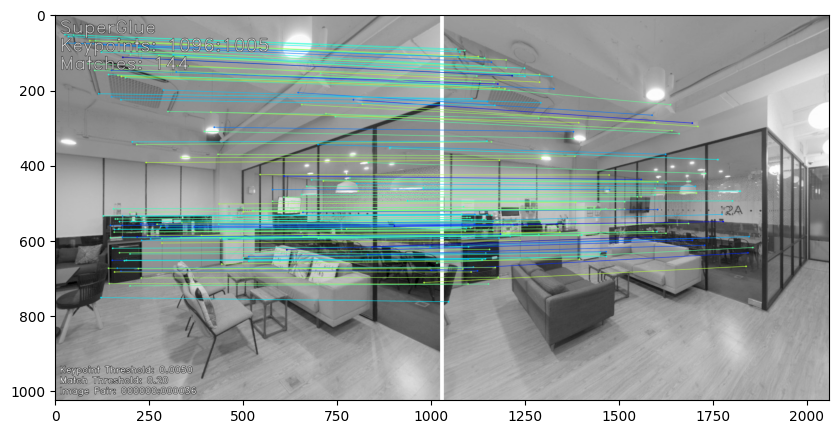

In [90]:
idx0, idx1 = get_path("002-02"), get_path("8_4")

print("-"*60+"\n", imgs[idx0], imgs[idx1],"\n"+"-"*60+"\n", )
# method : 'r2' or 'sp'
out = draw_glue(idx0, idx1, method = 'sp', threshold=5, k=400, epi=True)
plt.imshow(out)
plt.savefig('test_epi.jpg', dpi=600)

------------------------------------------------------------
 imgs/1024/002-02.png imgs/1024/8_4.png 
------------------------------------------------------------

Launching on GPUs 0

>> Creating net = Quad_L2Net_ConfCFS()
 ( Model size: 486K parameters )

Extracting features for imgs/1024/002-02.png


/home/muyaho/.conda/envs/pnp/lib/python3.8/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Launching on GPUs 0

>> Creating net = Quad_L2Net_ConfCFS()
 ( Model size: 486K parameters )

Extracting features for imgs/1024/8_4.png
(1096, 3) (1096, 256) (1024, 1024) (300, 3) (300, 128) (300,)
Loaded SuperGlue model ("indoor" weights)
[ -1 533 812 400  57  -1  -1 420 984  -1  63 453 734 602 579 364  -1 203
 458 345 719  -1  67  12 165  -1 435  -1  -1 349  -1  -1 731 539 285 133
  -1  42  45  -1  -1 756 915  -1  -1 293 143 354  -1 595  -1  -1 865  -1
 140 887  -1 651 150 311 638 260 499  -1 699  -1 913  -1  -1   7 858 389
 292 765 459  -1  -1  -1  -1  58 531  -1 841  -1 188  37  -1  -1 755  -1]
torch.Size([400, 3])


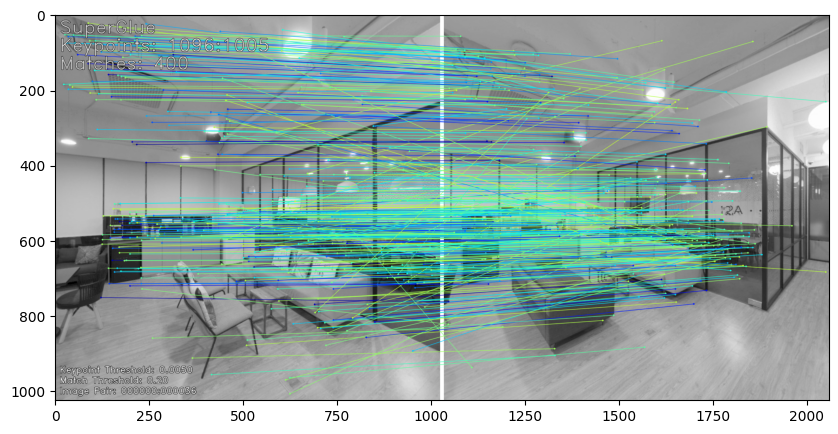

In [91]:
idx0, idx1 = get_path("002-02"), get_path("8_4")

print("-"*60+"\n", imgs[idx0], imgs[idx1],"\n"+"-"*60+"\n", )
# method : 'r2' or 'sp'
out = draw_glue(idx0, idx1, method = 'sp', threshold=5, k=400, epi=False)
plt.imshow(out)
plt.savefig('test.jpg', dpi=600)